## 5-fold cross validation

## 順序ロジスティック回帰

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import mord
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from scipy.stats import t

In [3]:
from sklearn.linear_model import LogisticRegression

## データの読み込み

In [4]:
df_1v2_reason95_orderlog0_livedum_all = pd.read_csv('df_1v2_reason95_orderlog0_livedum_all.csv')

C:\Users\GUESTUSER\AppData\Local\Temp\ipykernel_20416\1688623676.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1v2_reason95_orderlog0_livedum_all = pd.read_csv('df_1v2_reason95_orderlog0_livedum_all.csv')


In [5]:
df_1v2_reason95_orderlog0_livedum_all_land = pd.read_csv('df_1v2_reason95_orderlog0_livedum_all_land.csv')

In [6]:
df_1v2_reason95_orderlog0_livedum_all_build = pd.read_csv('df_1v2_reason95_orderlog0_livedum_all_build.csv')

In [7]:
df_1v2_reason95_orderlog0_livedum_all_subuild =  pd.read_csv('df_1v2_reason95_orderlog0_livedum_all_subuild.csv')

## 全データ

### 順序ロジスティック回帰　　
説明変数：新・既，official price, dummy_一棟を消去  
mord.logisticATからIT(クロスエントロピー関数へ)  
期間を変更(60日を追加)  
正規化

In [8]:
# 目的変数の作成 (categorize_period function remains unchanged)

def categorize_period(days):
    if days <= 30:
        return 1
    elif days <= 60:
        return 2
    elif days <= 90:
        return 3
    elif days <= 180:
        return 4
    elif days <= 360:
        return 5
    else:
        return 6

# ... (Assume df_1v2_reason95_orderlog0_livedum_all is already loaded)
df_1v2_reason95_orderlog0_livedum_all['sales1_category'] = df_1v2_reason95_orderlog0_livedum_all['sales1_period'].apply(categorize_period)

# 各クラスの数を計算
class_counts = df_1v2_reason95_orderlog0_livedum_all['sales1_category'].value_counts()

# 最小クラスの数を取得
min_class_count = class_counts.min()

# アンダーサンプリング
undersampled_df = pd.DataFrame()
for category in range(1, 7):
    class_data = df_1v2_reason95_orderlog0_livedum_all[df_1v2_reason95_orderlog0_livedum_all['sales1_category'] == category]
    undersampled_class_data = resample(class_data, 
                                     replace=False, 
                                     n_samples=min_class_count, 
                                     random_state=42)
    undersampled_df = pd.concat([undersampled_df, undersampled_class_data])

# 説明変数と目的変数を定義
y = undersampled_df['sales1_category']
X = undersampled_df[['population_density', 'month_sin', 'month_cos', 'size',   
                    'dummy_所有権移転遺贈・贈与その他無償名義', 'dummy_抹消登記', 'dummy_所有権移転相続・法人合併',
                    'dummy_処分の制限に関する登記', 'dummy_分筆', 'dummy_区分建物の表題', 'dummy_合筆', 'dummy_地目変更・更正', 
                    'dummy_地積変更・更正', 'dummy_所有権の保存(申請)', 'dummy_所有権移転その他の原因', 'dummy_抵当権の設定', 
                    'dummy_権利の変更・更正', 'dummy_権利の移転(所有権を除く)', 'dummy_滅失',
                    'dummy_登記名義人の氏名等についての変更・更正', 'dummy_表題',
                    'dummy_土地', 'dummy_建物', 'dummy_区分建物']]
    
# Cross-validationの準備
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = MinMaxScaler()

# 各Foldでの回帰係数を保存
coefficients = []

# 各FoldでのクラスごとのAUCスコアを保存
class_auc_scores = {cls: [] for cls in np.unique(y)}  # クラス1~6

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # データの正規化
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # モデルの学習
    model = mord.LogisticIT()
    model.fit(X_train_normalized, y_train)

    # 予測確率の取得
    y_pred_proba = model.predict_proba(X_test_normalized)
    
    # 各Foldの回帰係数を保存
    coefficients.append(model.coef_)

    # ***Crucial Change: Create y_onehot here***
    y_onehot = label_binarize(y_test, classes=np.unique(y))

    # 各クラスのAUCを計算して表示
    auc_per_class = {}
    for i, class_label in enumerate(np.unique(y)):
        auc = roc_auc_score(y_onehot[:, i], y_pred_proba[:, i])
        auc_per_class[class_label] = auc
        #print(f"AUC for class {class_label}: {auc:.3f}")
        class_auc_scores[class_label].append(auc)

# 回帰係数の平均値を計算
coefficients = np.array(coefficients)  # (n_folds, n_features)
mean_coefficients = coefficients.mean(axis=0)  # 各変数ごとの平均

# 説明変数名と平均回帰係数をデータフレームにまとめる
coef_df = pd.DataFrame({
    '変数': X.columns,
    '平均回帰係数': mean_coefficients
})

# 平均回帰係数を表示
#print(coef_df)

# Calculate mean and standard deviation of AUC for each class
auc_summary = {}
for cls, scores in class_auc_scores.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    auc_summary[cls] = {'mean': mean_auc, 'std': std_auc}

# Print results
print("AUC Summary (Mean and Standard Deviation per Class):")
for cls, summary in auc_summary.items():
    print(f"Class {cls}: Mean AUC = {summary['mean']:.4f}, Std Dev = {summary['std']:.4f}")

AUC Summary (Mean and Standard Deviation per Class):
Class 1: Mean AUC = 0.8149, Std Dev = 0.0036
Class 2: Mean AUC = 0.5948, Std Dev = 0.0033
Class 3: Mean AUC = 0.5967, Std Dev = 0.0027
Class 4: Mean AUC = 0.6045, Std Dev = 0.0020
Class 5: Mean AUC = 0.5990, Std Dev = 0.0040
Class 6: Mean AUC = 0.6817, Std Dev = 0.0026


In [13]:
coefficients

array([[-4.08284561e-04,  2.49897711e-02,  2.43600784e-02,
        -1.96904928e-02,  8.97346095e-02, -1.37883722e-01,
        -1.26326469e-01, -1.71289159e-03,  4.51764925e-01,
         7.65116609e-01, -2.78182491e-02,  7.80074045e-01,
         1.61556824e-01, -2.91490554e-01, -4.41422786e-01,
        -2.73558546e-01, -3.69539227e-02],
       [-3.04153202e-04,  3.06203692e-02,  3.28621709e-02,
        -4.52304358e-02,  1.08146040e-01, -1.32828617e-01,
        -1.35899554e-01, -6.54557864e-03,  4.65810618e-01,
         7.33730397e-01, -1.95700407e-04,  7.80565673e-01,
         1.68062895e-01, -2.55567921e-01, -3.76435091e-01,
        -2.63514587e-01,  0.00000000e+00],
       [ 6.67879426e-03,  2.67392149e-02,  2.90242346e-02,
        -2.95644972e-02,  1.34466730e-01, -1.33078874e-01,
        -1.13377476e-01,  6.45065478e-03,  4.72759278e-01,
         7.52452758e-01, -1.23259950e-02,  7.97379164e-01,
         1.31150331e-01, -2.79833550e-01, -4.72952429e-01,
        -2.57803920e-01, -3.7

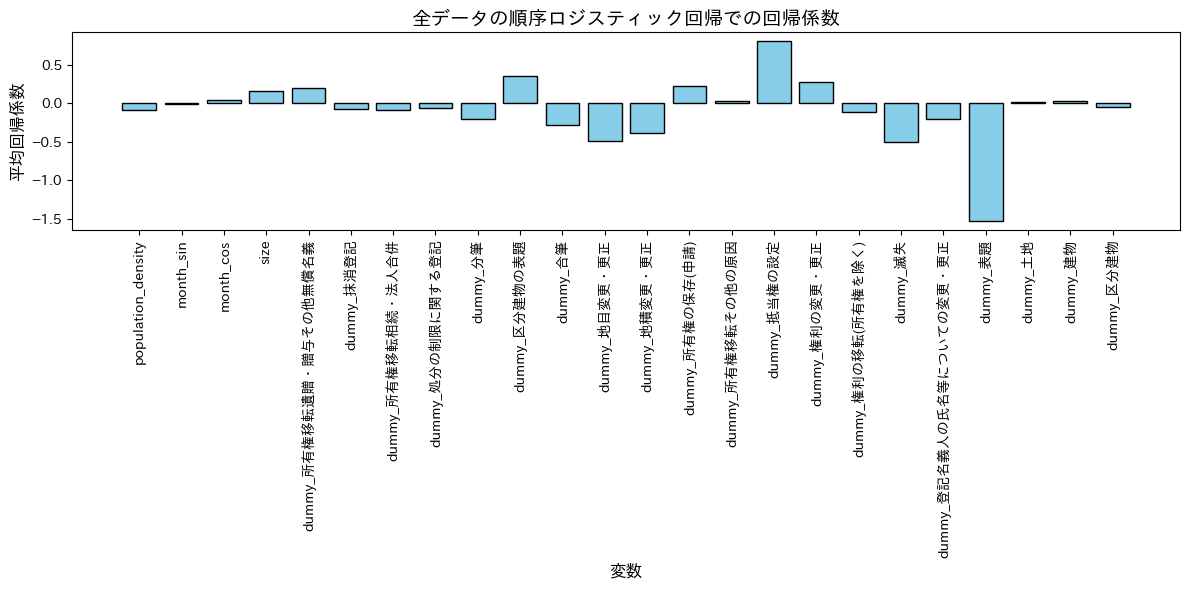

In [13]:
# 回帰係数の表示

plt.figure(figsize=(12, 6))
plt.bar(coef_df['変数'], coef_df['平均回帰係数'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('変数', fontsize=12)
plt.ylabel('平均回帰係数', fontsize=12)
plt.title('全データの順序ロジスティック回帰での回帰係数', fontsize=14)
plt.tight_layout()
plt.show()

## 土地

In [10]:
# 目的変数の作成
# sales1_periodを30、90、180、360のカテゴリに変換
def categorize_period(days):
    if days <= 30:
        return 1
    elif days <= 60:
        return 2
    elif days <= 90:
        return 3
    elif days <= 180:
        return 4
    elif days <= 360:
        return 5
    else:
        return 6

df_1v2_reason95_orderlog0_livedum_all_land['sales1_category'] = df_1v2_reason95_orderlog0_livedum_all_land['sales1_period'].apply(categorize_period)

# 各クラスの数を計算
class_counts = df_1v2_reason95_orderlog0_livedum_all_land['sales1_category'].value_counts()

# 最小クラスの数を取得
min_class_count = class_counts.min()

# アンダーサンプリング
undersampled_df = pd.DataFrame()
for category in range(1, 7):
    class_data = df_1v2_reason95_orderlog0_livedum_all_land[df_1v2_reason95_orderlog0_livedum_all_land['sales1_category'] == category]
    undersampled_class_data = resample(class_data, 
                                     replace=False, 
                                     n_samples=min_class_count, 
                                     random_state=42)
    undersampled_df = pd.concat([undersampled_df, undersampled_class_data])

# 説明変数と目的変数を定義
y = undersampled_df['sales1_category']
X = undersampled_df[['population_density', 'month_sin', 'month_cos', 'size',   
                    'dummy_所有権移転遺贈・贈与その他無償名義', 'dummy_抹消登記', 'dummy_所有権移転相続・法人合併',
                    'dummy_処分の制限に関する登記', 'dummy_分筆', 'dummy_合筆', 'dummy_地目変更・更正', 
                    'dummy_地積変更・更正', 'dummy_所有権の保存(申請)', 'dummy_所有権移転その他の原因', 'dummy_抵当権の設定', 
                    'dummy_権利の変更・更正', 'dummy_権利の移転(所有権を除く)', 'dummy_登記名義人の氏名等についての変更・更正', 'dummy_表題'
                    ]]
   
# Cross-validationの準備
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = MinMaxScaler()

# 各Foldでの回帰係数を保存
coefficients = []

# 各FoldでのクラスごとのAUCスコアを保存
class_auc_scores = {cls: [] for cls in np.unique(y)}  # クラス1~6

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # データの正規化
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # モデルの学習
    model = mord.LogisticIT()
    model.fit(X_train_normalized, y_train)

    # 予測確率の取得
    y_pred_proba = model.predict_proba(X_test_normalized)
    
    # 各Foldの回帰係数を保存
    coefficients.append(model.coef_)

    # ***Crucial Change: Create y_onehot here***
    y_onehot = label_binarize(y_test, classes=np.unique(y))

    # 各クラスのAUCを計算して表示
    auc_per_class = {}
    for i, class_label in enumerate(np.unique(y)):
        auc = roc_auc_score(y_onehot[:, i], y_pred_proba[:, i])
        auc_per_class[class_label] = auc
        #print(f"AUC for class {class_label}: {auc:.3f}")
        class_auc_scores[class_label].append(auc)

# 回帰係数の平均値を計算
coefficients = np.array(coefficients)  # (n_folds, n_features)
mean_coefficients = coefficients.mean(axis=0)  # 各変数ごとの平均

# 説明変数名と平均回帰係数をデータフレームにまとめる
coef_df = pd.DataFrame({
    '変数': X.columns,
    '平均回帰係数': mean_coefficients
})

# Calculate mean and standard deviation of AUC for each class
auc_summary = {}
for cls, scores in class_auc_scores.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    auc_summary[cls] = {'mean': mean_auc, 'std': std_auc}

# Print results
print("AUC Summary (Mean and Standard Deviation per Class):")
for cls, summary in auc_summary.items():
    print(f"Class {cls}: Mean AUC = {summary['mean']:.4f}, Std Dev = {summary['std']:.4f}")

AUC Summary (Mean and Standard Deviation per Class):
Class 1: Mean AUC = 0.6535, Std Dev = 0.0040
Class 2: Mean AUC = 0.5211, Std Dev = 0.0038
Class 3: Mean AUC = 0.5351, Std Dev = 0.0039
Class 4: Mean AUC = 0.5380, Std Dev = 0.0038
Class 5: Mean AUC = 0.5365, Std Dev = 0.0041
Class 6: Mean AUC = 0.6564, Std Dev = 0.0043


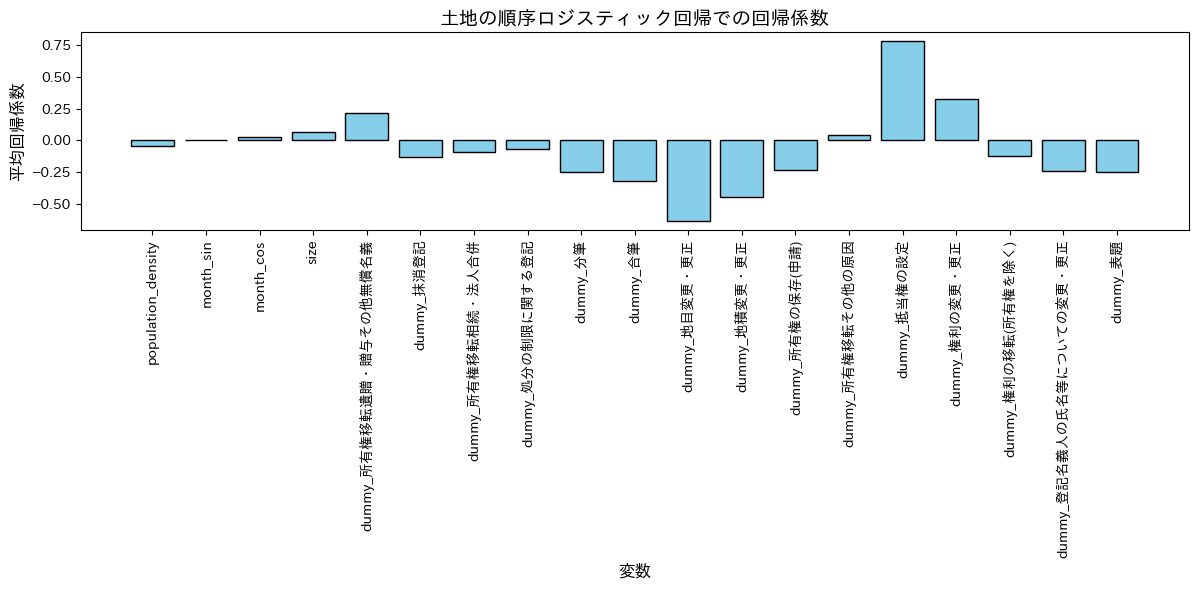

In [17]:
#回帰係数の出力

plt.figure(figsize=(12, 6))
plt.bar(coef_df['変数'], coef_df['平均回帰係数'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('変数', fontsize=12)
plt.ylabel('平均回帰係数', fontsize=12)
plt.title('土地の順序ロジスティック回帰での回帰係数', fontsize=14)
plt.tight_layout()
plt.show()

## 建物

In [11]:
# 目的変数の作成
# sales1_periodを30、90、180、360のカテゴリに変換
def categorize_period(days):
    if days <= 30:
        return 1
    elif days <= 60:
        return 2
    elif days <= 90:
        return 3
    elif days <= 180:
        return 4
    elif days <= 360:
        return 5
    else:
        return 6

df_1v2_reason95_orderlog0_livedum_all_build['sales1_category'] = df_1v2_reason95_orderlog0_livedum_all_build['sales1_period'].apply(categorize_period)

# 各クラスの数を計算
class_counts = df_1v2_reason95_orderlog0_livedum_all_build['sales1_category'].value_counts()

# 最小クラスの数を取得
min_class_count = class_counts.min()

# アンダーサンプリング
undersampled_df = pd.DataFrame()
for category in range(1, 7):
    class_data = df_1v2_reason95_orderlog0_livedum_all_build[df_1v2_reason95_orderlog0_livedum_all_build['sales1_category'] == category]
    undersampled_class_data = resample(class_data, 
                                     replace=False, 
                                     n_samples=min_class_count, 
                                     random_state=42)
    undersampled_df = pd.concat([undersampled_df, undersampled_class_data])

# 説明変数と目的変数を定義
y = undersampled_df['sales1_category']
X = undersampled_df[['population_density', 'month_sin', 'month_cos', 'size',   
                    'dummy_所有権移転遺贈・贈与その他無償名義', 'dummy_抹消登記', 'dummy_所有権移転相続・法人合併',
                    'dummy_処分の制限に関する登記', 'dummy_所有権の保存(申請)', 'dummy_所有権移転その他の原因', 'dummy_抵当権の設定', 
                    'dummy_権利の変更・更正', 'dummy_権利の移転(所有権を除く)', 'dummy_滅失',
                    'dummy_登記名義人の氏名等についての変更・更正', 'dummy_表題']]
   
# Cross-validationの準備
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = MinMaxScaler()

# 各Foldでの回帰係数を保存
coefficients = []

# 各FoldでのクラスごとのAUCスコアを保存
class_auc_scores = {cls: [] for cls in np.unique(y)}  # クラス1~6

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # データの正規化
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # モデルの学習
    model = mord.LogisticIT()
    model.fit(X_train_normalized, y_train)

    # 予測確率の取得
    y_pred_proba = model.predict_proba(X_test_normalized)
    
    # 各Foldの回帰係数を保存
    coefficients.append(model.coef_)

    # ***Crucial Change: Create y_onehot here***
    y_onehot = label_binarize(y_test, classes=np.unique(y))

    # 各クラスのAUCを計算して表示
    auc_per_class = {}
    for i, class_label in enumerate(np.unique(y)):
        auc = roc_auc_score(y_onehot[:, i], y_pred_proba[:, i])
        auc_per_class[class_label] = auc
        #print(f"AUC for class {class_label}: {auc:.3f}")
        class_auc_scores[class_label].append(auc)

# 回帰係数の平均値を計算
coefficients = np.array(coefficients)  # (n_folds, n_features)
mean_coefficients = coefficients.mean(axis=0)  # 各変数ごとの平均

# 説明変数名と平均回帰係数をデータフレームにまとめる
coef_df = pd.DataFrame({
    '変数': X.columns,
    '平均回帰係数': mean_coefficients
})

# Calculate mean and standard deviation of AUC for each class
auc_summary = {}
for cls, scores in class_auc_scores.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    auc_summary[cls] = {'mean': mean_auc, 'std': std_auc}

# Print results
print("AUC Summary (Mean and Standard Deviation per Class):")
for cls, summary in auc_summary.items():
    print(f"Class {cls}: Mean AUC = {summary['mean']:.4f}, Std Dev = {summary['std']:.4f}")

AUC Summary (Mean and Standard Deviation per Class):
Class 1: Mean AUC = 0.8226, Std Dev = 0.0060
Class 2: Mean AUC = 0.5431, Std Dev = 0.0037
Class 3: Mean AUC = 0.5820, Std Dev = 0.0105
Class 4: Mean AUC = 0.5888, Std Dev = 0.0453
Class 5: Mean AUC = 0.6484, Std Dev = 0.0051
Class 6: Mean AUC = 0.6573, Std Dev = 0.0113


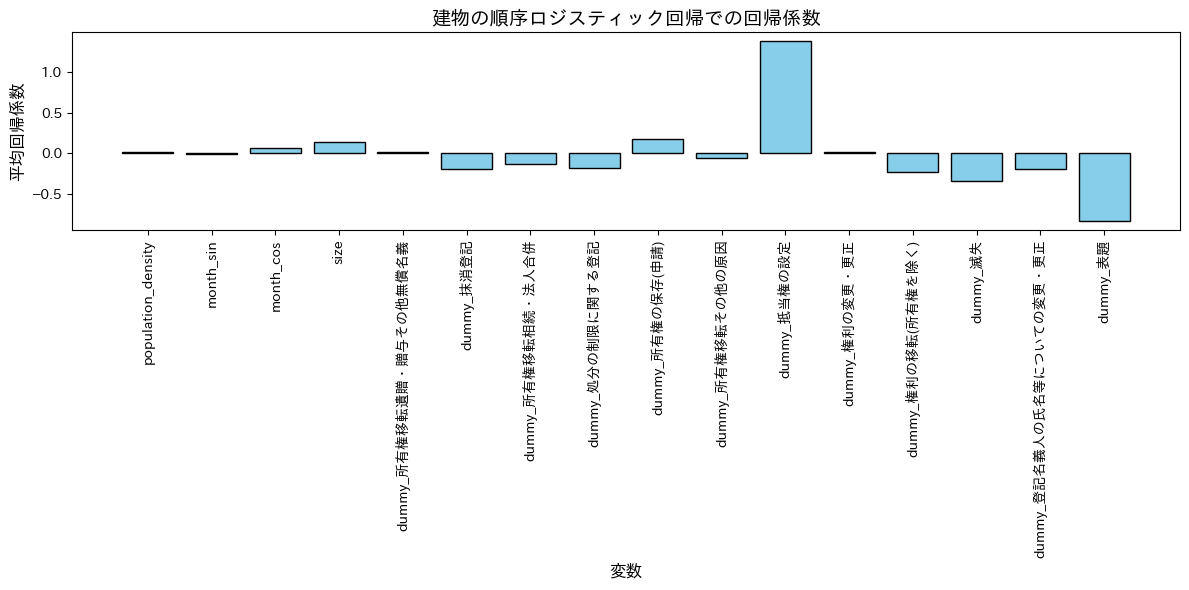

In [24]:
#回帰係数の出力

plt.figure(figsize=(12, 6))
plt.bar(coef_df['変数'], coef_df['平均回帰係数'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('変数', fontsize=12)
plt.ylabel('平均回帰係数', fontsize=12)
plt.title('建物の順序ロジスティック回帰での回帰係数', fontsize=14)
plt.tight_layout()
plt.show()

## 区分建物

In [12]:
# 目的変数の作成
# sales1_periodを30、90、180、360のカテゴリに変換
def categorize_period(days):
    if days <= 30:
        return 1
    elif days <= 60:
        return 2
    elif days <= 90:
        return 3
    elif days <= 180:
        return 4
    elif days <= 360:
        return 5
    else:
        return 6

df_1v2_reason95_orderlog0_livedum_all_subuild['sales1_category'] = df_1v2_reason95_orderlog0_livedum_all_subuild['sales1_period'].apply(categorize_period)

# 各クラスの数を計算
class_counts = df_1v2_reason95_orderlog0_livedum_all_subuild['sales1_category'].value_counts()

# 最小クラスの数を取得
min_class_count = class_counts.min()

# アンダーサンプリング
undersampled_df = pd.DataFrame()
for category in range(1, 7):
    class_data = df_1v2_reason95_orderlog0_livedum_all_subuild[df_1v2_reason95_orderlog0_livedum_all_subuild['sales1_category'] == category]
    undersampled_class_data = resample(class_data, 
                                     replace=False, 
                                     n_samples=min_class_count, 
                                     random_state=42)
    undersampled_df = pd.concat([undersampled_df, undersampled_class_data])

# 説明変数と目的変数を定義
y = undersampled_df['sales1_category']
X = undersampled_df[['population_density', 'month_sin', 'month_cos', 'size',   
                    'dummy_所有権移転遺贈・贈与その他無償名義', 'dummy_抹消登記', 'dummy_所有権移転相続・法人合併',
                    'dummy_処分の制限に関する登記', 'dummy_区分建物の表題', 
                    'dummy_所有権の保存(申請)', 'dummy_所有権移転その他の原因', 'dummy_抵当権の設定', 
                    'dummy_権利の変更・更正', 'dummy_権利の移転(所有権を除く)', 'dummy_滅失',
                    'dummy_登記名義人の氏名等についての変更・更正', 'dummy_表題']]
   
# Cross-validationの準備
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = MinMaxScaler()

# 各Foldでの回帰係数を保存
coefficients = []

# 各FoldでのクラスごとのAUCスコアを保存
class_auc_scores = {cls: [] for cls in np.unique(y)}  # クラス1~6

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # データの正規化
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # モデルの学習
    model = mord.LogisticIT()
    model.fit(X_train_normalized, y_train)

    # 予測確率の取得
    y_pred_proba = model.predict_proba(X_test_normalized)
    
    # 各Foldの回帰係数を保存
    coefficients.append(model.coef_)

    # ***Crucial Change: Create y_onehot here***
    y_onehot = label_binarize(y_test, classes=np.unique(y))

    # 各クラスのAUCを計算して表示
    auc_per_class = {}
    for i, class_label in enumerate(np.unique(y)):
        auc = roc_auc_score(y_onehot[:, i], y_pred_proba[:, i])
        auc_per_class[class_label] = auc
        #print(f"AUC for class {class_label}: {auc:.3f}")
        class_auc_scores[class_label].append(auc)

# 回帰係数の平均値を計算
coefficients = np.array(coefficients)  # (n_folds, n_features)
mean_coefficients = coefficients.mean(axis=0)  # 各変数ごとの平均

# 説明変数名と平均回帰係数をデータフレームにまとめる
coef_df = pd.DataFrame({
    '変数': X.columns,
    '平均回帰係数': mean_coefficients
})

# Calculate mean and standard deviation of AUC for each class
auc_summary = {}
for cls, scores in class_auc_scores.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    auc_summary[cls] = {'mean': mean_auc, 'std': std_auc}

# Print results
print("AUC Summary (Mean and Standard Deviation per Class):")
for cls, summary in auc_summary.items():
    print(f"Class {cls}: Mean AUC = {summary['mean']:.4f}, Std Dev = {summary['std']:.4f}")

AUC Summary (Mean and Standard Deviation per Class):
Class 1: Mean AUC = 0.6693, Std Dev = 0.0035
Class 2: Mean AUC = 0.5596, Std Dev = 0.0121
Class 3: Mean AUC = 0.5572, Std Dev = 0.0126
Class 4: Mean AUC = 0.5466, Std Dev = 0.0153
Class 5: Mean AUC = 0.5747, Std Dev = 0.0079
Class 6: Mean AUC = 0.6795, Std Dev = 0.0153


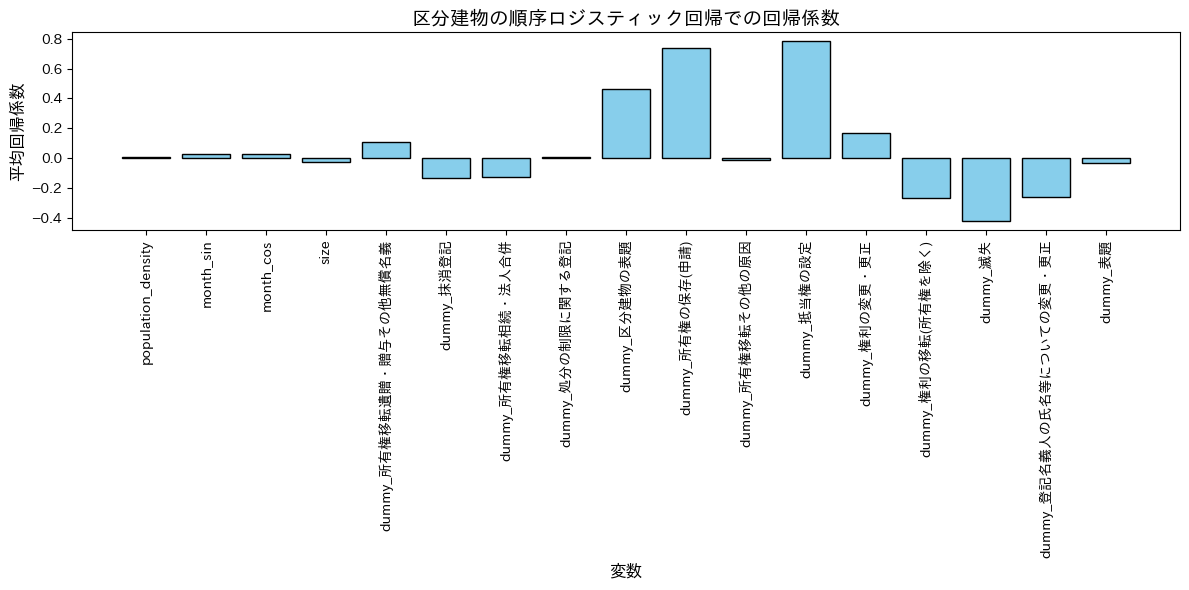

In [26]:
#回帰係数の出力

plt.figure(figsize=(12, 6))
plt.bar(coef_df['変数'], coef_df['平均回帰係数'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('変数', fontsize=12)
plt.ylabel('平均回帰係数', fontsize=12)
plt.title('区分建物の順序ロジスティック回帰での回帰係数', fontsize=14)
plt.tight_layout()
plt.show()